In diesem Notebook wird eine Grid Search durchgeführt, aber dieses Mal mit dem F1 Score der Artefaktklasse als scorere anstelle des macro F1 scores.

In [ ]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
from utils.training import get_features_and_labels
import joblib
from datetime import datetime

random_state = 42
feature_file = "./features/features.hdf5"
split_train = 'train'
data_split_file = "./data_split.yaml"
features = ['mean', 'variance', 'std', 'ptp_amp', 'kurtosis', 'quantile', 'pow_freq_bands', 'hurst_exp', 'line_length',
            'rms', 'higuchi_fd', 'spect_entropy', 'svd_entropy', 'teager_kaiser_energy', 'wavelet_coef_energy',
            'zero_crossings']
model_save_path = f'./models/{datetime.now().strftime('%d-%m-%y %H-%M-%S')}.joblib'

params = {
    'class_weight': ['balanced'],
    'max_depth': [20, 25, 30, 35, 40],
    'max_features': ['log2', 'sqrt', None],
}

X_train, y_train = get_features_and_labels(feature_file, features, split_train, data_split_file)

clf = RandomForestClassifier(random_state=42, n_jobs=-1)
cv_splitter = StratifiedKFold(5, shuffle=True, random_state=42)
gcv = GridSearchCV(clf, params, cv=cv_splitter, scoring='f1', n_jobs=1, verbose=1, return_train_score=True)

gcv.fit(X_train, y_train)

df = pd.DataFrame(gcv.cv_results_)
df.to_csv('output/exp_03_10_cv_results.csv', index=False)

joblib.dump(gcv.best_estimator_, model_save_path)

Extracting features and labels for sessions: 100%|██████████| 268/268 [00:06<00:00, 38.49it/s]


Fitting 5 folds for each of 15 candidates, totalling 75 fits


['./models/01-12-25 07-45-45.joblib']

Auch im Folgenden wird der beste estimator auf dem Validierungsset bewertet.

In [5]:
import joblib
from utils.training import get_features_and_labels
from sklearn.metrics import classification_report


split_val = 'val'
feature_file = "./features/features.hdf5"
data_split_file = "./data_split.yaml"
features = ['mean', 'variance', 'std', 'ptp_amp', 'kurtosis', 'quantile', 'pow_freq_bands', 'hurst_exp', 'line_length',
            'rms', 'higuchi_fd', 'spect_entropy', 'svd_entropy', 'teager_kaiser_energy', 'wavelet_coef_energy',
            'zero_crossings']

clf = joblib.load('./models/01-12-25 07-45-45.joblib')

X_val, y_val = get_features_and_labels(feature_file, features, split_val, data_split_file)
y_pred = clf.predict(X_val)
print(f'Classifiction report validtation set \n\n{classification_report(y_val, y_pred, target_names=["Kein Artefakt", "Artefakt"])}')

Extracting features and labels for sessions: 100%|██████████| 268/268 [00:01<00:00, 139.79it/s]


Classifiction report validtation set 

               precision    recall  f1-score   support

Kein Artefakt       0.92      0.89      0.91    971776
     Artefakt       0.57      0.66      0.61    210350

     accuracy                           0.85   1182126
    macro avg       0.74      0.77      0.76   1182126
 weighted avg       0.86      0.85      0.85   1182126



In [6]:
import joblib
from utils.training import predict_random_forest
from utils.evaluation import get_iou_for_set
import numpy as np
import matplotlib.pyplot as plt

split_val = 'val'
feature_file = "./features/features.hdf5"
data_split_file = "./data_split.yaml"
features = ['mean', 'variance', 'std', 'ptp_amp', 'kurtosis', 'quantile', 'pow_freq_bands', 'hurst_exp', 'line_length',
            'rms', 'higuchi_fd', 'spect_entropy', 'svd_entropy', 'teager_kaiser_energy', 'wavelet_coef_energy',
            'zero_crossings']
overlap_treshold_values = np.linspace(0, 1, num = 21)

precision_values_val = []
recall_values_val = []
f1_values_val = []

clf = joblib.load('./models/01-12-25 07-45-45.joblib')

_, y_pred_val = predict_random_forest(clf, feature_file, features, data_split_file, 'val')

for overlap_treshold in overlap_treshold_values:
    precision_val, recall_val, f1_val = get_iou_for_set(overlap_treshold, y_pred_val, data_split_file, 'val', feature_file)

    precision_values_val.append(precision_val)
    recall_values_val.append(recall_val)
    f1_values_val.append(f1_val)

Extracting features and labels for sessions: 100%|██████████| 268/268 [00:01<00:00, 204.79it/s]


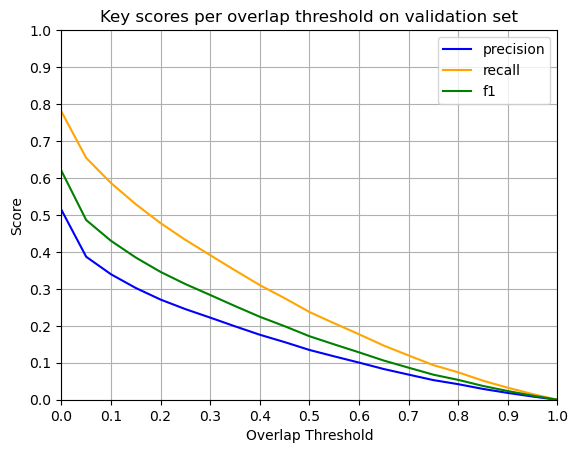

In [7]:
import numpy as np
import matplotlib.pyplot as plt

ticks = np.linspace(0, 1, num=11)

plt.xticks(ticks)
plt.yticks(ticks)

plt.plot(overlap_treshold_values, precision_values_val, label='precision', color='blue')
plt.plot(overlap_treshold_values, recall_values_val, label='recall', color='orange')
plt.plot(overlap_treshold_values, f1_values_val, label='f1', color='green')

plt.xlabel('Overlap Threshold')
plt.ylabel('Score')
plt.title('Key scores per overlap threshold on validation set')
plt.grid(True)
plt.legend()
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.savefig('output/exp_03_10_iou_f1_val_best_estimator.pdf', bbox_inches='tight')
plt.show()